In [15]:
import numpy as np
import sympy as sy
from copy import copy
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.special import comb
from functools import partial



### Library


In [16]:

def append_state(state, index_list, is_fermion = False, ne = 1):
    if is_fermion == True:
        my_sum = 0
        for i in copy(index_list):
            if i>1:
                return
            my_sum = my_sum+i
        if my_sum!=ne:
            return
    state.append(copy(index_list))
    return


def for_recursive(number_of_loops, range_list, state, current_index=0, iter_list = [], is_fermion = False, ne =0):
    if iter_list == []:
        iter_list = [0]*number_of_loops

    if current_index == number_of_loops-1:
        for iter_list[current_index] in range_list[current_index]:
            append_state(state, iter_list, is_fermion, ne)
    else:
        for iter_list[current_index] in range_list[current_index]:
            for_recursive(number_of_loops, iter_list = iter_list, range_list = range_list,  current_index = current_index+1, state= state, is_fermion = is_fermion, ne =ne) 


#### Fock space


class state():
    
    def __init__(self, x,y,pre_factor=1, show=False):
        self.psi_e = x
        self.psi_ph =y
        self.pre_factor = pre_factor
        self.ev = []
        self.ew = []
        self.evT = []
        self.ewT = []
        if show:
            self.show()
        return
    
    def show(self, end=0):
        '''prints current state'''
        
        if self.pre_factor != 1:
            print(sy.S(str(f)), end ="")
        print("|", end ="")
        for e in range(len(self.psi_e)):
            if e == len(self.psi_e)-1:
                print(self.psi_e[e], end ="")
            else:
                print(self.psi_e[e], end =",")
        print(">",end ="")
        print(" |", end ="")
        for ph in range(len(self.psi_ph)):
            if ph == len(self.psi_ph)-1:
                print(self.psi_ph[ph], end ="")
            else:
                print(self.psi_ph[ph], end =",")
        if end==0:
            print(">")
        else:
            print(">", end =" ")
        return
    
    def number_of_phonons(self,j=-1):
        if j==-1:
            return sum(self.psi_ph)
        else:
            return self.psi_ph[j]
    
    def e_index(self,i):
        """returns periodic index i with periode n_e"""
        return i%self.n_e
    
    def C_plus(self,i):
        if self.psi_e[self.e_index(i)]== 0:
            self.psi_e[self.e_index(i)] = 1
        elif self.psi_e[self.e_index(i)]== 1:
            self.psi_e[self.e_index(i)] = 0
            self.pre_factor = self.pre_factor * 0
        return
    
    def C_(self,i):
        if self.psi_e[self.e_index(i)]== 1:
            self.psi_e[self.e_index(i)] = 0
        elif self.psi_e[self.e_index(i)]== 0:
            self.psi_e[self.e_index(i)] = 0
            self.pre_factor = self.pre_factor * 0
        return
    
    def b_plus(self,i):
        if self.psi_ph[i] == self.M:
            self.psi_ph[i] = 0
            self.pre_factor = self.pre_factor * 0
        else: 
            self.psi_ph[i] = self.psi_ph[i] + 1
        return
    
    def b_(self,i):
        if self.psi_ph[i] == 0:
            self.psi_ph[i] = 0
            self.pre_factor = self.pre_factor * 0
        else: 
            self.psi_ph[i] = self.psi_ph[i] - 1
        return
    def Omega_(self,i):
        self.pre_factor = self.psi_e[self.e_index(i)]
        return 
        
        
class H_space():
    def __init__(self, L, M, n_e, show, is_periodic = False):
        self.L=L
        self.M=M
        self.n_e=n_e
        self.states = []
        #self.TH_matrix = np.array([np.array([0.0 for i in range(self.dim_mat)]) for j in range(self.L*(self.M+1)**self.L)])
        self.make_basis(L, M, n_e, show)
        self.dim_mat = comb(L,n_e,exact=True)*(M+1)**L
        self.is_periodic = is_periodic
        if self.dim_mat!= len(self.states):
            print("dim is wrong!")
        self.H_matrix = np.array([np.array([0 for i in range(self.dim_mat)]) for j in range(self.dim_mat)])
        return
                    
    def make_basis(self, L, M, n_e, show):
        ph_states = []
        e_states = []
        for_recursive(range_list = [range(M+1) for _ in range(L)], state = ph_states , number_of_loops=L)
        for_recursive(range_list = [range(n_e+1) for _ in range(L)], state = e_states , number_of_loops=L, is_fermion = True, ne =n_e)
        for x in e_states:
            for y in ph_states:
                self.states.append(state(copy(x),copy(y),1, show=show))

    def e_jump_left(self,i):
        """C⁺C applied to the i-th basis state
        returns if the result is within nummerical basis,
        index of result and normalizazion factor
        """
        if self.n_e == 0 or self.n_e == self.L:
            return False, 0, 0
        elif  (i + (self.M+1)**2) < 2* (self.M+1)**2 and (i + (self.M+1)**2) >=0:
            return True,(i + (self.M+1)**2), 1
        elif self.is_periodic:
            return True,(i + (self.M+1)**2)% (2*(self.M+1)**2), 1
        else:
            return False, 0, 0
    def e_jump_right(self,i):
        """C⁺C applied to the i-th basis state
        returns if the result is within nummerical basis,
        index of result and normalizazion factor
        """
        if self.n_e == 0 or self.n_e == self.L:
            return False, 0, 0
        elif  (i - (self.M+1)**2) < 2* (self.M+1)**2 and (i - (self.M+1)**2) >=0:
            return True,(i - (self.M+1)**2), 1
        elif self.is_periodic:
            return True,(i - (self.M+1)**2)% (2*(self.M+1)**2), 1
        else:
            return False, 0, 0
        
    def b_plus(self,i,j=1):
        """B⁺_j applied to the i-th basis state
        returns if the result is within nummerical basis,
        index of result and normalizazion factor
        """
        if (( i + (self.M+1)**j )//( (self.M+1)**j) ) %(self.M+1)!=0:
            f = i+(self.M+1)**j
            return True, f, np.sqrt(self.states[f].psi_ph[self.L-j-1])
        else:
            return False, 0, 0
    
    def b(self,i,j=1):
        """B_j applied to the i-th basis state
        returns if the result is within nummerical basis,
        index of result and normalizazion factor
        """
        if (( i - (self.M+1)**j )//( (self.M+1)**j) ) %(self.M+1)!=self.M:
            return True,i-(self.M+1)**j , np.sqrt(self.states[i].psi_ph[self.L-j-1])
        else:
            return False, 0, 0
    def Hamiltonian(self,t_0, w_0, gamma):
        """calculate the hamiltonian on the standard basis"""
        self.H_matrix = self.H_matrix = np.array([np.array([0.0 for i in range(self.dim_mat)]) for j in range(self.dim_mat)])
        for i in range(self.dim_mat):
            a,b,k = self.e_jump_left(i)
            c,d,l = self.e_jump_right(i)
            if a:
                self.H_matrix[i][b] += -t_0*k
            if c:
                self.H_matrix[i][d] += -t_0*l
            self.H_matrix[i][i] += w_0 * self.states[i].number_of_phonons()
            for j in range(self.L):
                if self.states[i].psi_e[self.L-j-1] == 1:
                    e,f, m = self.b_plus(i,j)
                    if e:
                        #print("Ob+ (",self.L-j-1,")", end="")
                        #self.states[i].show()
                        #print("=", end="")
                        #self.states[f].show()
                        #print(m**2)
                        self.H_matrix[i][f] += -gamma * m 
                        #np.sqrt(self.states[f].psi_ph[self.L-j-1])
                    g,h, n = self.b(i,j)
                    if g:
                        #print("Ob (",self.L-j-1,")", end=" ")
                        #self.states[i].show()
                        #print("=", end="")
                        #self.states[h].show()
                        #print(n**2)
                        self.H_matrix[i][h] += -gamma * n
                        #np.sqrt(self.states[i].psi_ph[self.L-j-1])
                    
        return
    def H_diag(self):
        """diagonalizes the Himiltonian and sets ew as Eigenvalues and ev as Eigenvectors"""
        self.ew, self.ev = eigh(self.H_matrix)#np.linalg.eig(self.H_matrix)
        test = []
        for x in range(len(self.ew)):
            if abs(self.ew[x].imag) <1e-15:
                test.append(self.ew[x].real)
            else: 
                test.append(self.ew[x])
        self.ew = test
        return
    def check_symmetric(self, tol=1e-10):
        """checks wheather the Hamiltonian is a symmetric matrix
        with an error tolarence tol"""
        return np.all(np.abs(self.H_matrix-self.H_matrix.T) < tol)
    
    def O_(self, psi, O, order =1 ):
        """maps a state psi into a list of operators O apllied to it. 
        the parameter order specifies the potence of the operators.
        |psi> |--> (O[0]O[1]..O[n])^order |psi>
        """
        if len(O)==1:
            if order == 0:
                print("identity")
                return psi
            elif order == 1:
                res = np.array([0.0 for _ in range(self.dim_mat)]) 
                for i in range(self.dim_mat):
                    j,k,l = O[0](i)
                    if j:
                        res[k] = psi[i] *l
                return res
            elif order>1:
                return self.O_(psi, [O[0]], order -1)
            else:
                print("negative Operation potence")
                return np.array([0.0 for _ in range(self.dim_mat)])
        elif len(O)>1:
            return self.O_(self.O_(psi, [O[-1]], order),  O[:-1], order)
    
    def Expected_value(self, O, beta):
        Z = sum([np.exp(-beta* w) for w in self.ew])
        a = sum([np.exp(-beta* self.ew[n]) * np.array(self.ev[n]) @ self.O_(self.ev[n]/(np.array(self.ev[n]) @np.array(self.ev[n])),O) \
                 /(np.array(self.ev[n]) @np.array(self.ev[n])) \
                 for n in range(len(self.ew))])
        return a/Z
    
    def b_plus_b(self,i,j=1):
        ##B⁺B
        aa,bb,cc = self.b(i,j)
        if aa:
            e,f,g = self.b_plus(bb,j)
            return True, f, cc*g
            """if e:
                return True, f, cc*g
            else:
                return False, 0, 0
        """
        else:
                return False, 0, 0
    
    def b_b_plus(self,i,j=1):
        ##BB+
        aa,bb,cc = self.b_plus(i,j)
        if aa:
            e,f,g = self.b(bb,j)
            return True, f, cc*g
            """if e:
                return True, f, cc*g
            else:
                return False, 0, 0
        """
        else:
                return False, 0, 0
    
    def E_moments(self, beta, m, is_T=False):
        """calculates the m-th moment of E for the system with inverse temperature beta"""
        if is_T:
            Z = sum([np.exp(-beta* w) for w in self.ewT])
            a = sum([np.exp(-beta* w) *w**m  for w in self.ewT])
        else:
            Z = sum([np.exp(-beta* w) for w in self.ew])
            a = sum([np.exp(-beta* w) *w**m  for w in self.ew])
        return a/Z
    
    def C_v(self, beta, is_T=False):
        """calculates the heat capacity for the system with inverse temperature beta"""
        return beta**2 *( self.E_moments(beta,2,is_T = is_T) -self.E_moments(beta,1,is_T = is_T)**2)
    
    def T(self ,i, order=1):
        """Translation operator returnes index of the translated state i after
        (order)-times translations"""
        if order==0:
            return i
        elif order==1:
            m_1 = self.states[i].number_of_phonons(0)
            m_2 = self.states[i].number_of_phonons(1) 
            delete_phonons = (i)//((self.M+1)**2) *((self.M+1)**2)
            if self.n_e==0 or self.n_e==self.L:
                exchange_electron=0
            else:
                exchange_electron = (delete_phonons - (self.M+1)**2)% (2*(self.M+1)**2)
            add_phonons = exchange_electron+m_1 + m_2*((self.M+1)**1)
            return add_phonons
        else: 
            return self.T(i, order-1)

    
    def checkstate(self,s,k):
        """checks if the state has been 
        already used as a representative and returns
        the states periodicity (-1) for invalid rep."""
        R=-1 ## periodicity
        t = copy(s)
        for i in range(self.L):
            t = self.T(t)
            if t < s:
                ## epresentative of |s〉 is already in the basi
                return R
            elif t == s:
                ##peridoicity is i
                if abs(np.round(k*(i+1),0)-k*(i+1))<1e-10:
                #k % (self.L/(i+1)) !=0:
                    ## state are compatiple with momentum k
                    if (i+1)==1 and k==1:
                        return -1
                    return (i+1)
                #R = i+1
        return R
            
    def find_T_reps(self,k):
        reps = []
        periodicities = []
        for s in range(self.dim_mat):
            R = self.checkstate(s,k)
            if R>=0:
                reps.append(s)
                periodicities.append(R)
        return reps, periodicities
        
    def representative(self, s_):
        r, t, l = s_,s_,0 
        for i in range(self.L): ## should it be (1,self.L-1)?
            t = self.T(t)
            if t < r:
                r=t
                l=i
                return r, l ## representative, number of translations
        return r, l
    
    def T_H_matrix(self,t_0, w_0, gamma, k):
        reps, periodicities = self.find_T_reps(k)
        TH_matrix = np.array([np.array([0.0 for i in range(len(reps))])\
                              for j in range(len(reps))],dtype = 'complex_')
        #print(reps)
        for i in range(len(reps)):
            a=i#reps[i]
            TH_matrix[a][a]+=w_0 * self.states[reps[i]].number_of_phonons()
            
            aa,bb,kk = self.e_jump_left(reps[i])
            cc,dd,ll = self.e_jump_right(reps[i])
            if aa:
                b, R_b = self.representative(bb)
                if b in reps:
                    b = reps.index(b)
                    TH_matrix[a][b] += -t_0*kk *np.sqrt(periodicities[b]/periodicities[a])\
                    *np.exp(1j*2*np.pi*(k+R_b)/self.L)

            if cc:
                b, R_b = self.representative(dd)
                if b in reps:
                    b = reps.index(b)
                    TH_matrix[a][b] += -t_0*ll*np.sqrt(periodicities[b]/periodicities[a])\
                    *np.exp(1j*2*np.pi*(k+R_b)/self.L)
            for j in range(self.L):
                if self.states[reps[i]].psi_e[self.L-j-1] == 1:
                    ee,ff, mm = self.b_plus(reps[i],j)
                    if ee:
                        b, R_b = self.representative(ff)
                        #print("B⁺",j," |",reps[i],"> =", b)
                        if b in reps:
                            b = reps.index(b)
                            TH_matrix[a][b] += -gamma * mm * np.sqrt(periodicities[b]/\
                                                                 periodicities[a])\
                            *np.exp(1j*2*np.pi*(k+R_b)/self.L)
                    gg,hh, nn = self.b(reps[i],j)
                    if gg:
                        b, R_b = self.representative(hh)
                        #print("B",j," |",reps[i],"> =", b)
                        if b in reps:
                            
                            b = reps.index(b)
                            TH_matrix[a][b] += -gamma * nn * np.sqrt(periodicities[b]\
                                                                     /periodicities[a])\
                            *np.exp(1j*2*np.pi*(k+R_b)/self.L)
                        
    
        return TH_matrix
        
    def HT_diag(self, t_0, w_0, gamma, show = False):
        """diagonalizes the Himiltonian starting from the momentum basis
        and sets ewT as Eigenvalues and evT as Eigenvectors"""
        H2= self.T_H_matrix(t_0, w_0, gamma, 0)
        H1= self.T_H_matrix(t_0, w_0, gamma, 1)
        
        if show:
            print(np.round(H1,1))
            print(np.round(H2,1))
        w1,v1 = eigh(H1)#np.linalg.eig(self.H_matrix)
        w2,v2 = eigh(H2)
        test = []
        self.ewT, self.evT = [w for w in w1],[v for v in v1]
        for x in range(len(w2)):
            self.ewT.append(w2[x])
            self.evT.append(v2[x])   
        for x in range(len(self.ewT)):
            if abs(self.ewT[x].imag) <1e-15:
                test.append(self.ewT[x].real)
            else: 
                test.append(self.ewT[x])
        self.ewT = test
        data_list = list(sorted(zip(self.ewT,self.evT), key=lambda x: x[0]))
        unzipped_list = [[i for i, j in data_list],\
                 [j for i, j in data_list]]
        self.ewT,self.evT = unzipped_list[0],unzipped_list[1]
        return


##### energy expectation of the system in the infinite temperature limit

In [17]:
beta = 0
t_0 = 1
w_0 = 1
gamma = 1
M_list2 = [f for f in range(20)]
E = [0.0 for f in range(len(M_list2))]
for t in range(len(M_list2)):
    H = H_space(L=2,M=M_list2[t],n_e=1, show = False, is_periodic = True)
    #H.Hamiltonian(t_0,w_0,gamma)
    H.HT_diag(t_0,w_0,gamma)
    E[t] = H.E_moments(beta,1, is_T = True)    

In [26]:
Evs_M = np.array([M_list2,E] )
np.save('Evs_M',Evs_M)

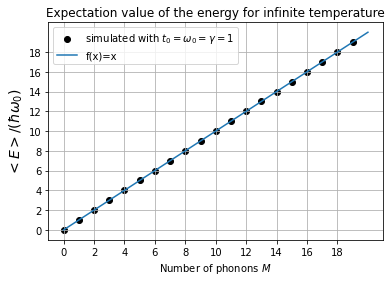

In [25]:
x=np.linspace(0,20,1000)
#plt.plot(M_list2,E,'.')
plt.rcParams["figure.figsize"] = (6,4)

plt.xticks(np.arange(0, 20, 2))
plt.yticks(np.arange(0, 20, 2))
plt.scatter(Evs_M[0],np.round(Evs_M[1],14), color='black', label =r'simulated with $t_0=\omega_0=\gamma=1$')
#plt.plot(x,(x*0)+-gamma**2/w_0, label =r'$-\gamma^2/\omega_0$')
plt.plot(x,x, label =r'f(x)=x')
plt.title("Expectation value of the energy for infinite temperature")
plt.xlabel(xlabel=r'Number of phonons 'r'$M$')
plt.ylabel(ylabel=r'$<E>/(\hbar\omega_0)$', fontsize = 14.)
plt.grid()
#plt.grid()
plt.legend()
#plt.savefig("Evs_M.pdf", bbox_inches='tight')

##### convergence behaviour of $E_0$ for $t_0=0$

In [27]:
M=20
t_0 = 0
w_0 = 1
gamma = 3
M_list = [f for f in range(20)]
for i in range(4):
    M_list.append(20+10*(i))
    M_list.append(25+10*(i))
E_0 = [0.0 for f in M_list]
E_0T = [0.0 for f in M_list]
for t in range(len(M_list)):
    H, ew, ewT = [],[], []
    H = H_space(L=2,M=M_list[t],n_e=1, show = False, is_periodic = True)
    H.Hamiltonian(t_0,w_0,gamma)
    H.H_diag()
    H.HT_diag(t_0, w_0, gamma)
    E_0[t] = np.amin(H.ew)
    E_0T[t] = np.amin(H.ewT)


In [28]:
E_0_vs_M = np.array([M_list,E_0,E_0T] )
np.save('E_0_vs_M',E_0_vs_M)

In [29]:

x = np.linspace(0,56,1000)
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(E_0_vs_M[0],E_0_vs_M[1],'.', color='black', label ="numerical basis")
plt.plot(E_0_vs_M[0],E_0_vs_M[2],'.', color='g', label ="momentum basis")
plt.plot(x,(x*0)+-gamma**2/w_0, label =r'$-\gamma^2/\omega_0$ in units of $\hbar\omega_0$')
plt.title("Convergence behaviour of \nthe ground state energy  for $t_0=0$")
plt.xlabel(xlabel='Number of phonons 'r'$M$')
plt.ylabel(ylabel=r'$E_0/(\hbar\omega_0)$', fontsize = 14.)
plt.grid()
plt.legend()
plt.savefig("E_0_vs_M.png")


#### energy expectation and heat capacity general case

In [30]:
p = (1,2,3)
E_values = []
C_v_values = []
M_list3=[0,4,12,20,35]
#beta_values = np.concatenate((np.linspace(0.001,1,100),np.linspace(1,10,100)))
#T_values = np.linspace(0.001,200,1000)
T_values = np.concatenate((np.linspace(0.001,1,100),np.linspace(1,100,1000)))
beta_values = 1/(T_values)
for m in M_list3: 
    H = H_space(L=2,M=m,n_e=1, show = False, is_periodic = True)
    #H.Hamiltonian()
    H.HT_diag(p[0],p[1],p[2])
    E_values.append(np.array([H.E_moments(beta_values[i],1,is_T = True) for i in range(len(beta_values))]))
    C_v_values.append(np.array([H.C_v(beta_values[i],is_T = True) for i in range(len(beta_values))]))
    

/tmp/ipykernel_498873/3145843638.py:295: RuntimeWarning: overflow encountered in exp
  Z = sum([np.exp(-beta* w) for w in self.ewT])
/tmp/ipykernel_498873/3145843638.py:296: RuntimeWarning: overflow encountered in exp
  a = sum([np.exp(-beta* w) *w**m  for w in self.ewT])
/tmp/ipykernel_498873/3145843638.py:300: RuntimeWarning: invalid value encountered in double_scalars
  return a/Z


In [33]:
#E_C_vs_T = np.array([M_list3,T_values,E_values, C_v_values ])
#np.save('E_C_vs_T',E_C_vs_T)

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
for m in range(len(M_list3)):
    axs[0].plot(1/beta_values, E_values[m], label="M="+str(M_list3[m]))
for m in range(len(M_list3)):
    axs[1].plot(1/beta_values, C_v_values[m], label="M="+str(M_list3[m]))
axs[0].set_xlabel(r'$T/t_0$')
axs[0].set_ylabel(r'$<E>/t_0$')
axs[0].legend()
axs[0].grid()
axs[1].set_xlabel(r'$T/t_0$')
axs[1].set_ylabel(r'$C_v$')
axs[1].legend()
axs[1].grid()
axs[1].set_title('Heat capacity')
axs[0].set_title('Expectation value of the energy')
plt.savefig("E_C_vs_T.pdf", bbox_inches='tight')

#### energy expectation and heat capacity one electron no allowed phonons

In [36]:
### theoretical values

def C_v_kin(beta):
    return (4*beta)**2 *(np.exp(-4*beta))/(np.exp(-4*beta)+1)**2
def Ekin(beta):
    return -2*(1-np.exp(-4*beta))/(1+np.exp(-4*beta))


In [35]:
#p = (1,2,3)
M_list3=[0,4,12,20,35]
T_values = np.concatenate((np.linspace(0.01,1,100),np.linspace(1,40,1000)))
#T_values = np.linspace(0.001,200,1000)
beta_values = 1/(T_values)
E_kinvalues = []
C_v_valuesk = []
for m in M_list3:
    H = H_space(L=2,M=M,n_e=1, show = False, is_periodic = True)
    H.Hamiltonian(1,0,0)
    H.H_diag()
    #H.HT_diag(1,0,0)
    E_kinvalues.append(np.array([H.E_moments(beta_values[i],1,is_T = False) for i in range(len(beta_values))]))
    C_v_valuesk.append(np.array([H.C_v(beta_values[i],is_T = False) for i in range(len(beta_values))]))


In [37]:


fig, axs = plt.subplots(1, 2, figsize=(10,5))
for m in range(len(M_list3)):
    axs[0].plot(1/beta_values, E_kinvalues[m], label="M="+str(M_list3[m]))
for m in range(len(M_list3)):
    axs[1].plot(1/beta_values, C_v_valuesk[m], label="M="+str(M_list3[m]))

axs[1].plot(1/beta_values,C_v_kin(beta_values), label = "theoretical curve ")
axs[0].plot(1/beta_values,Ekin(beta_values), label = "theoretical curve ")

axs[0].set_xlabel(r'$T/t_0$')
axs[0].set_ylabel(r'$<E>/t_0$')
axs[0].legend()
axs[0].grid()
axs[1].set_xlabel(r'$T/t_0$')
axs[1].set_ylabel(r'$C_v$')
axs[1].legend()
axs[1].grid()
axs[1].set_title('Heat capacity')
axs[0].set_title('Expectation value of the energy')
plt.savefig("E_C_kin_vs_T.pdf", bbox_inches='tight')

#### ground state energy revisited

In [51]:
@np.vectorize
def Emin_match2(w_0, gamma):
    H = H_space(L=2,M=20,n_e=1, show = False, is_periodic = True)
    #H.Hamiltonian(0,w_0,gamma)
    #H.H_diag()
    H.HT_diag(0,w_0,gamma)
    E_0 = np.amin(H.ewT)
    return (-gamma**2/w_0)-E_0
@np.vectorize
def Emin_match3(w_0, gamma):
    H = H_space(L=2,M=25,n_e=1, show = False, is_periodic = True)
    #H.Hamiltonian(0,w_0,gamma)
    #H.H_diag()
    H.HT_diag(0,w_0,gamma)
    E_0 = np.amin(H.ewT)
    return (-gamma**2/w_0)-E_0

@np.vectorize
def Emin_match4(w_0, gamma):
    H = H_space(L=2,M=30,n_e=1, show = False, is_periodic = True)
    #H.Hamiltonian(0,w_0,gamma)
    #H.H_diag()
    H.HT_diag(0,w_0,gamma)
    E_0 = np.amin(H.ewT)
    return (-gamma**2/w_0)-E_0
@np.vectorize
def Emin_match5(w_0, gamma):
    H = H_space(L=2,M=35,n_e=1, show = False, is_periodic = True)
    #H.Hamiltonian(0,w_0,gamma)
    #H.H_diag()
    H.HT_diag(0,w_0,gamma)
    E_0 = np.amin(H.ewT)
    return (-gamma**2/w_0)-E_0


In [52]:
x = np.linspace(0.01,2);
y = np.linspace(-2,2);
[X,Y] = np.meshgrid(x,y);
z = Emin_match2(X,Y)
z3 = Emin_match3(X,Y)
z4 = Emin_match4(X,Y)
z5 = Emin_match5(X,Y)

In [56]:
np.save('z',z)
np.save('z3',z3)
np.save('z4',z4)
np.save('z5',z5)

In [49]:
#z = np.load('z.npy')
#z3 = np.load('z3.npy')
#z4 = np.load('z4.npy')
#z5 = np.load('z5.npy')

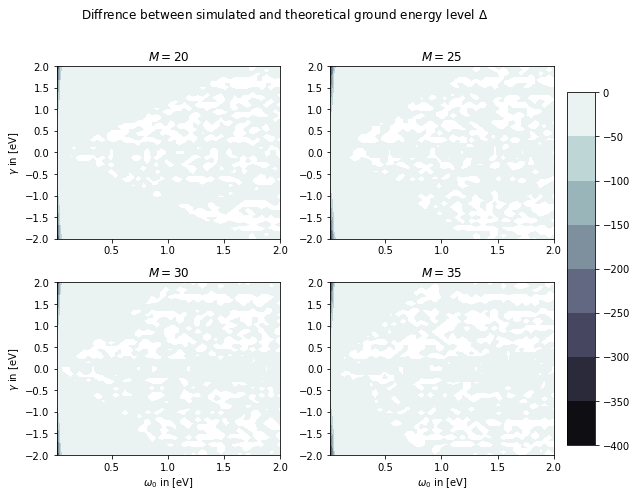

In [55]:
fig, axs = plt.subplots(2, 2, figsize=(8,7))
fig.suptitle('Diffrence between simulated and theoretical ground energy level $\Delta$\n')

axs[0,0].contourf(X, Y, z,cmap ="bone")
axs[0,0].set_ylabel(ylabel=r'$\gamma$ in [eV]')#, fontsize = 14.)

axs[0,1].contourf(X, Y, z3,cmap ="bone")

axs[1,0].contourf(X, Y, z4,cmap ="bone")
axs[1,0].set_ylabel(ylabel=r'$\gamma$ in [eV]')#, fontsize = 14.)

axs[1,1].contourf(X, Y, z5,cmap ="bone")
axs[1,0].set_xlabel(xlabel="$\omega_0$ in [eV]")
axs[1,1].set_xlabel(xlabel="$\omega_0$ in [eV]")
#axs[2,0].set_ylabel(ylabel=r'$I$', fontsize = 14.)

#axs[2,1].plot(solt_12_const, state_12_const[12+lk], 'tab:red', label = "Konstanter Ansatz 12 Landkreise")
#axs[2,1].set_xlabel(xlabel='Zeit in Tage')


axs[0,0].set_title('$M=20$')
axs[0,1].set_title('$M=25$')
axs[1,0].set_title('$M=30$')
axs[1,1].set_title('$M=35$')
fig.tight_layout()
#plt.colorbar(fig, ax=axs[1,0])
#plt.colorbar(fig, ax=ax)
cbar_ax = fig.add_axes([0.99, 0.11, 0.05, 0.7])
fig.colorbar(axs[0,0].contourf(X, Y, z,cmap ="bone"), cax=cbar_ax)
plt.savefig("E_0_vs all.pdf", bbox_inches='tight')